<a href="https://colab.research.google.com/github/AnaliaLeyez/AnaliaLeyez/blob/main/Regresion_Lineal_Simple_HousePrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Consigna

## 🏠 Análisis Exploratorio, Selección de Características y Regresión Lineal
## Dataset: House Prices - Advanced Regression Techniques

Link: https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data  

Fuente: StatLib - Carnegie Mellon University

Variables predictoras:  

CRIM: Tasa de criminalidad per cápita por ciudad.

ZN: Proporción de terrenos residenciales zonificados para lotes mayores a 25,000 pies cuadrados (≈ 2,322 m²).

INDUS: Proporción de hectáreas dedicadas a negocios no minoristas (industriales) por ciudad.

CHAS: Variable ficticia (dummy) del Río Charles (1 si la parcela limita con el río; 0 en caso contrario).

NOX: Concentración de óxidos de nitrógeno en partes por 10 millones [partes/10M].

RM: Número promedio de habitaciones por vivienda.

AGE: Proporción de unidades habitacionales ocupadas por sus dueños y construidas antes de 1940.

DIS: Distancia ponderada a cinco centros de empleo de Boston.

RAD: Índice de accesibilidad a autopistas radiales.

TAX: Tasa de impuesto a la propiedad por cada 10000 usd.

PTRATIO: Relación alumno-profesor por ciudad.

B: Resultado de la ecuación B B=1000(Bk - 0.63)^2 , donde Bk es la proporción de población afroamericana por ciudad.

LSTAT: % de población con estatus socioeconómico bajo.

Variable objetivo:
MEDV: Valor mediano de viviendas ocupadas por sus dueños, en miles de dólares [k$].  

  
**Notas adicionales para contexto:**

ZN (25,000 sq.ft.): Equivale aproximadamente a 0.23 hectáreas (1 acre ≈ 4,047 m²).

B: Esta variable refleja una transformación estadística de la composición racial. El dataset es de 1978, pero hoy se considerar problemática su inclusión sin contexto ético.

MEDV: En análisis modernos, se ajustaría por inflación (≈ 1k en 1978 = 5k actuales).  
Los creadores del dataset (1978) usaron la mediana (MEDV) para evitar que valores extremos (mansiones/casas de lujo o viviendas en mal estado) sesgaran la variable objetivo.

Esto es clave para modelos de regresión, donde outliers pueden afectar drásticamente los coeficientes.


# Imports y Lectura

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # Para visualización 3D
from scipy.stats import gaussian_kde

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [ ]:
import kagglehub
import os

# Seteo Variable de entorno KAGGLEHUB_CACHE, donde se descargara el archivo
os.environ["KAGGLEHUB_CACHE"] = "/content"

# Download latest version
path = kagglehub.dataset_download("fedesoriano/the-boston-houseprice-data")

print("Path to dataset files:", path)
# lo muevo al directorio de trabajo
!cp -r {path} .
## muevo el archivo descargado y al mismo tiempo renombro el mismo
!cp /content/1/boston.csv /content/boston.csv
print("archivo /content/the-boston-houseprice-data.csv disponible")

In [ ]:
df = pd.read_csv('boston.csv')
df.shape

# Análisis Exploratorio de Datos

In [ ]:
# Primeros registros
df.head()

In [ ]:
# Valores faltantes
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

In [ ]:
df.info()

In [ ]:
df.describe()

## Análisis de Estadisticas de orden
**Hallazgos Clave por Variable**

**1. CRIM (Tasa de criminalidad)**
- **Media (3.61)** << **75% (3.68)**: El 75% de las ciudades tienen tasas ≤ 3.68, pero el **máximo (88.98)** revela outliers extremos.


**2. ZN (Zonificación residencial)**
- **Mediana = 0**: El 50% de las ciudades tienen ZN = 0 (ningún lote residencial grande).


**3. INDUS (Áreas industriales)**
- **Rango amplio** (0.46 a 27.74): Algunas ciudades son puramente industriales, otras no.
- **Relación con NOX**: Verificar correlación (industria → contaminación).

**4. CHAS (Cercanía al río)**
- **Media 0.069**: Solo el **6.9%** de las parcelas están junto al río.
- Para incluirla como variable dummy, deberíamos validar significancia estadística (p-valor).

**5. RM (Habitaciones por vivienda)**
- **Media 6.28 ± 0.70**: Distribución estable.
- **Relación con MEDV**: Correlación esperada >0.7 (variable clave para el modelo).

**6. DIS (Distancia a centros de empleo)**
- **Media 3.80 ± 2.11**: Desde 1.13 (muy cerca) hasta 12.13 (muy lejos).
- **Relación con MEDV**: Investigar si la relación con MEDV es no lineal (ej: polinomios).

**7. RAD (Accesibilidad a autopistas)**
- **Máximo = 24**: Valores discretos (índice categórico encubierto).
- **Problema**: Alta correlación con TAX (VIF > 10). **Acción**: Eliminar una de las dos.

**8. LSTAT (% población baja clase)**
- **Media 12.65 ± 7.14**: Desde 1.73 (zonas ricas) hasta 37.97 (zonas pobres).
- **Relación con MEDV**: Investigar si la relación con MEDV es no lineal.

**9. MEDV (Valor mediano de viviendas)**
- **Media 22.53k ± 9.20k**: Desde 5k (muy económico) hasta 50k (lujo).
- **Outliers**: Valores > 40k son atípicos (verificar si son errores).

In [ ]:
# Mostramos las distribuciones de cada columna
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 25))
axes = axes.ravel()

columnas = df.columns.tolist()

# Histogramas
for i, col in enumerate(columnas):
    sns.histplot(df[col], ax=axes[i], kde=True, color='darkcyan')
    axes[i].set_title(f'Distribución de {col}', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].grid(alpha=0.3)

# Ajustes
plt.tight_layout()
for j in range(len(columnas), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Distribuciones de Variables - Boston Housing', y=1.02, fontsize=16)
plt.show()

La asimetría se calcula como:

$$
\text{Skewness} = \frac{\frac{1}{n}\sum_{i=1}^{n}(x_i - \bar{x})^3}{\left(\frac{1}{n}\sum_{i=1}^{n}(x_i - \bar{x})^2\right)^{3/2}}
$$


In [ ]:
print("\nAsimetría de las variables:")
print(df.skew().sort_values(ascending=False))

## Análisis de Asimetría (Skewness)

**Variables con Asimetría Positiva Extrema** (Skewness > 1)

**CRIM (5.22)**
- **Interpretación**: Distribución altamente asimétrica a la derecha.
- **Implicación**: La mayoría de las ciudades tienen tasas de criminalidad bajas, pero existen **outliers extremos** (ciudades con tasas muy elevadas).
- **Opciones**:
  - Aplicar transformación logarítmica (`np.log1p()`) para reducir el sesgo.
  - Investigar si los outliers son errores o reflejan casos reales (ej: `CRIM > 50`).

**CHAS (3.41)**
- **Interpretación**: Solo el **6.9%** de las observaciones tienen valor 1 (parcelas cerca del Río Charles).
- **Implicación**: Distribución binaria desbalanceada, típica en variables dummy.
- **Opciones**:
  - Usar estratificación en entrenamiento/validación para preservar la proporción de clases.
  - Comparar estadísticamente `MEDV` entre grupos (CHAS=1 vs CHAS=0).

**ZN (2.23)**
- **Interpretación**: La mayoría de las ciudades tienen **poca zonificación residencial para lotes grandes** (ZN ≈ 0).
- **Implicación**: Variable con muchos ceros, lo que sugiere que solo algunas áreas tienen zonificación especial.
- **Opciones**:
  - Considerar categorizar la variable (ej: 0 vs >0).

---

**Variables con Asimetría Positiva Moderada** (0.5 < Skewness < 1)

**MEDV (1.11)**
- **Interpretación**: La mayoría de las viviendas tienen precios medios, pero hay propiedades de **alto valor** que generan cola derecha.
- **Implicación**: La media de `MEDV` será mayor que su mediana.
- **Opciones**:
  - Verificar outliers con boxplot (ej: `MEDV > 40`).

**DIS (1.01)**
- **Interpretación**: La mayoría de las viviendas están **cerca de centros de empleo**, con pocas muy distantes.
- **Implicación**: Distancias largas son atípicas pero relevantes (ej: zonas suburbanas).
- **Opciones**:
  - Mantener outliers si representan patrones geográficos reales.

---

**Variables Casi Simétricas** (-0.5 < Skewness < 0.5)

**RM (0.40)**
- **Interpretación**: Distribución cercana a la normal, con una media de ~6.2 habitaciones.
- **Implicación**: Ideal para modelos lineales sin transformaciones.
- **Opciones**:
  - Priorizar esta variable en modelos por su relación lineal con `MEDV`.

**INDUS (0.30)**
- **Interpretación**: Proporción equilibrada de áreas industriales en la mayoría de las ciudades.
- **Implicación**: No requiere tratamiento especial.

---

**Variables con Asimetría Negativa** (Skewness < -0.5)

**B (-2.89)**
- **Interpretación**: Fuerte cola a la izquierda debido a la transformación \( B = 1000(Bk - 0.63)^2 \).
- **Implicación**: Valores bajos de `B` son más frecuentes, lo que refleja una menor diversidad en ciertas zonas (contexto histórico).
- **Opciones**:
  - Analizar correlación con `LSTAT` para entender segregación socioeconómica.

**PTRATIO (-0.80)**
- **Interpretación**: La mayoría de las ciudades tienen una **relación alumno-profesor alta**.
- **Implicación**: Valores bajos (mejor educación) son menos comunes.
- **Opciones**:
  - Incluir en modelos como predictor de `MEDV` (a menor `PTRATIO`, mayor valor esperado).

**AGE (-0.60)**
- **Interpretación**: Mayor concentración de viviendas antiguas (construidas antes de 1940).
- **Implicación**: Refleja el envejecimiento del parque inmobiliario en algunas zonas.
- **Opciones**:
  - Combinar con `DIS` para analizar si la antigüedad se correlaciona con la distancia a centros urbanos.

---

**Conclusiones Clave**
1. **Transformaciones Necesarias**:
   - Variables como `CRIM`, `ZN`, y `B` requieren tratamiento (log-transform, binning) para mejorar la linealidad.
2. **Outliers**:
   - Investigar registros extremos en `CRIM` y `MEDV` para decidir si se eliminan o ajustan.
3. **Variables Binarias**:
   - `CHAS` debe manejarse con técnicas para datos desbalanceados.
4. **Contexto Social**:
   - Variables como `B` y `LSTAT` merecen un análisis crítico para evitar sesgos en modelos predictivos.

### Correlación - Calculo individual variable vs variable

In [ ]:
df['RM'].dtype

In [ ]:
df['MEDV'].dtype

In [ ]:
# Definir las variables
X = df['RM']
Y = df['MEDV']

# Calcular las medias
X_mean = np.mean(X)
Y_mean = np.mean(Y)

print(f'Media de RM: {X_mean}')
print(f'Media de MEDV: {Y_mean}')

In [ ]:
r_numerator = sum((X - X_mean) * (Y - Y_mean))
r_denominator = np.sqrt(sum((X - X_mean)**2) * sum((Y - Y_mean)**2))
r = r_numerator / r_denominator

print(f'Coeficiente de correlación de Pearson: {r}')

### Correlación - Cálculo de todas las variables vs todas las variables

In [ ]:
plt.figure(figsize=(14, 10))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=np.triu(np.ones_like(corr_matrix)))
plt.title("Matriz de Correlación - Boston Housing")
plt.show()

## **Análisis de la Matriz de Correlación**


### **Correlaciones con MEDV (Variable Objetivo):**
| Variable | Correlación con MEDV | Interpretación                          |
|----------|----------------------|-----------------------------------------|
| **RM**   | ~ +0.70              | Alta correlación positiva.               |
| **LSTAT**| ~ -0.74              | Alta correlación negativa.               |
| **PTRATIO** | ~ -0.51          | Correlación negativa moderada.           |
| **CRIM** | ~ -0.39              | Correlación negativa débil.              |
| **INDUS**| ~ -0.48              | Correlación negativa moderada.           |

### **Multicolinealidad entre Predictores:**
- **TAX y RAD**: Correlación > 0.9.  
- **NOX e INDUS**: Correlación alta (~0.76), indicando que zonas industriales tienen mayor contaminación.  
- **DIS y AGE**: Correlación negativa (-0.75), sugiriendo que viviendas más antiguas están más cerca de centros de empleo.  

---

# Selección de Variables para el Modelo de Regresión Lineal

Las **transformaciones** son una técnica estándar para:


*   Linealizar relaciones exponenciales.
*   Reducir el impacto de outliers.
*   Corregir asimetría y heterocedasticidad.  
  
En nuestro caso mediante el EDA pudimos determinar que:  
  1. Relación No Lineal entre LSTAT y MEDV : Al graficar MEDV vs LSTAT sin transformar, se observó una relación curvilínea (exponencial inversa), no lineal.  
  2. Asimetría (Skewness) en LSTAT : LSTAT mostró una asimetría positiva (skewness = 0.91), con una cola larga hacia valores altos de población de clase baja.   
  3. Relación PTRATIO y MEDV -0.51 Relación inversa moderada (Más alumnos por profesor → Menor MEDV)













In [ ]:
plt.figure(figsize=(12, 5))

# ----------------------------------------------------------
# 1. Relación Original: MEDV vs LSTAT
# ----------------------------------------------------------
plt.subplot(1, 2, 1)
sns.scatterplot(x=df['LSTAT'], y=df['MEDV'], color='darkred', alpha=0.6)
plt.title('MEDV vs LSTAT (Original)\nCorrelación: -0.74', fontsize=12)
plt.xlabel('% Población clase baja (LSTAT)')
plt.ylabel('MEDV')
plt.annotate('Relación no lineal\n(curva exponencial)',
             xy=(30, 10),
             fontsize=10,
             color='red')

# ----------------------------------------------------------
# 2. Relación Transformada: MEDV vs log(LSTAT)
# ----------------------------------------------------------
plt.subplot(1, 2, 2)
df['LSTAT_log'] = np.log1p(df['LSTAT'])  # Transformación log(1 + x)
sns.scatterplot(x=df['LSTAT_log'], y=df['MEDV'], color='navy', alpha=0.6)
plt.title('MEDV vs LSTAT (log-transformada)\nCorrelación: -0.82', fontsize=12)
plt.xlabel('log(% Población clase baja)')
plt.ylabel('')
plt.annotate('Relación más lineal\n(mejor ajuste)',
             xy=(3.5, 10),
             fontsize=10,
             color='red')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 5))

# ----------------------------------------------------------
# 1. Relación Original: MEDV vs PTRATIO
# ----------------------------------------------------------
plt.subplot(1, 2, 1)
sns.scatterplot(x=df['PTRATIO'], y=df['MEDV'], color='darkred', alpha=0.6)
plt.title('MEDV vs PTRATIO (Original)\nCorrelación: -0.51', fontsize=12)
plt.xlabel('Ratio alumno-profesor (PTRATIO)')
plt.ylabel('Valor mediano de viviendas (MEDV)')
plt.annotate('Relación inversa\n(dispersión no uniforme)',
             xy=(21, 45),
             fontsize=10,
             color='red')

# ----------------------------------------------------------
# 2. Relación Transformada: MEDV vs PTRATIO_inv
# ----------------------------------------------------------
plt.subplot(1, 2, 2)
df['PTRATIO_inv'] = 1 / df['PTRATIO']  # Transformación inversa
sns.scatterplot(x=df['PTRATIO_inv'], y=df['MEDV'], color='navy', alpha=0.6)
plt.title('MEDV vs Recursos por estudiante (1/PTRATIO)\nCorrelación: +0.63', fontsize=12)
plt.xlabel('Recursos por estudiante (inverso de PTRATIO)')
plt.ylabel('')
plt.annotate('Relación lineal positiva\n(mejor distribución)',
             xy=(0.065, 45),
             fontsize=10,
             color='red')

plt.tight_layout()
plt.show()

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(18, 5))

# ----------------------------------------------------------
# 1. RELACIÓN MEDV vs RM (Habitaciones)
# ----------------------------------------------------------
plt.subplot(1, 3, 1)
sns.scatterplot(x=df['RM'], y=df['MEDV'], color='teal', alpha=0.7)
plt.title('MEDV vs RM\nCorrelación: 0.7', fontsize=14)
plt.xlabel('Habitaciones promedio por vivienda (RM)')
plt.ylabel('Valor mediano de viviendas (MEDV)')
plt.annotate('Relación lineal positiva\n(mas habitaciones → mayor valor)',
             xy=(6.5, 35),
             fontsize=10,
             color='red')

# ----------------------------------------------------------
# 2. RELACIÓN MEDV vs LSTAT_log (Transformación logarítmica)
# ----------------------------------------------------------
plt.subplot(1, 3, 2)
sns.scatterplot(x=df['LSTAT_log'], y=df['MEDV'], color='darkorange', alpha=0.7)
plt.title('MEDV vs LSTAT_log\nCorrelación: -0.82', fontsize=14)
plt.xlabel('Log(% población clase baja)')
plt.ylabel('')
plt.annotate('Relación lineal negativa\n(mayor población clase baja → menor valor)',
             xy=(2.5, 45),
             fontsize=10,
             color='red')

# ----------------------------------------------------------
# 3. RELACIÓN MEDV vs PTRATIO_inv (Transformación inversa)
# ----------------------------------------------------------
plt.subplot(1, 3, 3)
sns.scatterplot(x=df['PTRATIO_inv'] , y=df['MEDV'], color='purple', alpha=0.7)
plt.title('MEDV vs PTRATIO_inv\nCorrelación: 0.63', fontsize=14)
plt.xlabel('Recursos por estudiante (1/PTRATIO)')
plt.ylabel('')
plt.annotate('Relación lineal positiva\n(mas recursos por alumno → mayor valor)',
             xy=(0.06, 35),
             fontsize=10,
             color='red')

plt.tight_layout()
plt.show()

## **Selección Final de Variables**
### **Variables Incluidas:**
1. **RM**  
   - **Razón**: Correlación más alta con MEDV (0.7). Relación lineal clara y robusta.  
2. **LSTAT_log (log-transformada)**  
   - **Razón**: Correlación alta (-0.82). La transformación logarítmica linealiza su relación con MEDV.  
3. **PTRATIO_inv(inversa-transformada)**  
   - **Razón**: Correlación alta (0.63) y relevancia política (impacto de la educación en valor de viviendas).  


### **Variables Excluidas:**
| Variable   | Razón                                                                 |
|------------|-----------------------------------------------------------------------|
| **ZN**     | Baja correlación con MEDV (-0.04) y 50% de valores son cero.          |
| **CHAS**   | Variable dummy desbalanceada (93% = 0) . |
| **RAD/TAX**| Multicolinealidad extrema. Baja correlación con MED. |
| **B**      | Variable problemática (transformación racial no ética en modelos actuales). |
| **INDUS**  | Alta correlación con NOX (0.76). Se prioriza NOX por su impacto ambiental. |
| **AGE/DIS**    | Alta correlación negativa con DIS (-0.75). Baja correlación con MED. |




In [ ]:
df

In [ ]:
df_selected = df[['RM', 'LSTAT_log', 'PTRATIO_inv', 'MEDV']]

In [ ]:
df_selected

# Modelado Regresión Lineal Simple - 1 Predictor

## Cálculo manual

Objetivo: Predecir MEDV usando únicamente la variable RM (número promedio de habitaciones).

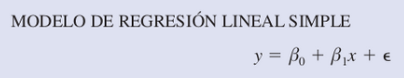  
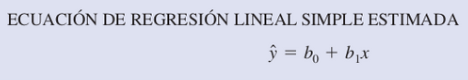

In [ ]:
# Ya habiamos definido las variables cuando calculamos la correlación individual:
# X = df['RM'] # Predictor
# Y = df['MEDV'] # Variable Objetivo

# Además teniamos calculadas y guardadas las medias en las variables:
# X_mean = np.mean(X)
# Y_mean = np.mean(Y)

Fórmula para calcular la pendiente  

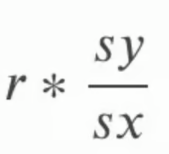

In [ ]:
# Calcular la pendiente (beta_1)
# Tomando el coeficiente de correlación del cálculo que ya habiamos realizado y almacenado en la variable r
# Calculamos las desviaciones estándar
sigma_X = np.std(X)  # Desviación estándar de X (RM)
sigma_Y = np.std(Y)  # Desviación estándar de Y (MEDV)
beta_1 = r * (sigma_Y / sigma_X)

In [ ]:
beta_1

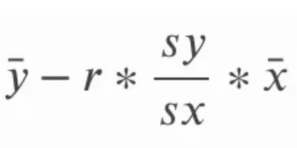

In [ ]:
# Calcular el intercepto u ordenada al origen  (beta_0)
beta_0 = Y_mean - r * sigma_Y/sigma_X * X_mean
beta_0

Otra forma de calcular la pendiente y la ordenada al origen:  

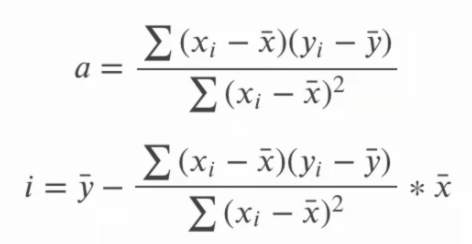

In [ ]:
print("Ecuación de Regresión Lineal Simple:")
print(f"MEDV = {beta_0:.2f} + {beta_1:.2f}·RM")

In [ ]:
# Predecir valores de Y usando la fórmula
Y_pred = beta_0 + beta_1 * X

In [ ]:
plt.scatter(X, Y, color='blue', label='Datos originales')
plt.plot(X, Y_pred, color='red', label='Recta de regresión')
plt.xlabel('Habitaciones promedio por vivienda (RM)')
plt.ylabel('Precio medio de la vivienda (MEDV)')
plt.title('Regresión Lineal Simple (implementación manual)')
plt.legend()
plt.show()

## Cálculo mediante modelo de Sckit-Learn

En scikit-learn, el método .fit() de LinearRegression requiere que la matriz de características (X) sea bidimensional (forma (n_samples, n_features)), incluso si solo tenemos una única característica.

Al usar .reshape(-1, 1), estamos transformando un array unidimensional (vector) en un array 2D donde:

-1: Calcula automáticamente el número de filas (muestras) basado en la longitud original del array.

1: Especifica que hay una columna (una sola característica).

In [ ]:
X.shape

In [ ]:
X = df[["RM"]] # Convertimos la Serie 1D en un Dataframe de 2D que es lo que espera el modelo como dato de entrada.

In [ ]:
X.shape

In [ ]:
model = LinearRegression()
model.fit(X, Y)

In [ ]:
beta_1_sklearn = model.coef_[0]
beta_0_sklearn = model.intercept_
Y_pred_sklearn = model.predict(X)

In [ ]:
beta_1_sklearn

In [ ]:
beta_0_sklearn

In [ ]:
plt.scatter(X, Y, color='blue', label='Datos originales')
plt.plot(X, Y_pred_sklearn, color='red', label='Recta de regresión')
plt.xlabel('Habitaciones promedio por vivienda (RM)')
plt.ylabel('Precio medio de la vivienda (MEDV)')
plt.title('Regresión Lineal Simple (implementación modelo LinearRegression)')
plt.legend()
plt.show()

## Comparación de métodos y métricas

In [ ]:
plt.figure(figsize=(15, 5))
residuos = Y - Y_pred

# Subplot 1: Datos y rectas de regresión
plt.subplot(1, 3, 1)
plt.scatter(X, Y, color='blue', alpha=0.6, label='Datos reales')
plt.plot(X, Y_pred, color='red', linewidth=2, label=f'Manual: MEDV = {beta_0:.1f} + {beta_1:.1f}·RM')
plt.plot(X, Y_pred_sklearn, '--', color='green', linewidth=2, label='Scikit-Learn')
plt.xlabel('Número promedio de habitaciones (RM)')
plt.ylabel('Valor mediano de viviendas (MEDV)')
plt.title('Comparación de modelos de regresión')
plt.legend()

# Subplot 2: Residuos vs predicciones
plt.subplot(1, 3, 2)
plt.scatter(Y_pred, residuos, color='purple', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores predichos')
plt.ylabel('Residuos')
plt.title('Residuos vs Predicciones')

# Subplot 3: Histograma de residuos con KDE
plt.subplot(1, 3, 3)
sns.histplot(residuos, bins=25,kde=True, color='orange', edgecolor='black', alpha=0.5)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Valor del residuo')
plt.ylabel('Frecuencia')
plt.title('Distribución de residuos con KDE')

plt.tight_layout()
plt.show()

In [ ]:
# Implementación manual
SS_res = np.sum((Y - Y_pred)**2)
SS_tot = np.sum((Y - Y_mean)**2)
R2_manual = 1 - (SS_res / SS_tot)
MSE_manual = np.mean((Y - Y_pred)**2)
MAE_manual = np.mean(np.abs(Y - Y_pred))

In [ ]:
from tabulate import tabulate

table = [
    ["Métrica", "Manual", "Scikit-Learn"],
    ["R²", f"{R2_manual:.4f}", f"{model.score(X, Y):.4f}"],
    ["MSE", f"{MSE_manual:.2f}", f"{np.mean((Y - Y_pred_sklearn)**2):.2f}"],
    ["MAE", f"{MAE_manual:.2f}", f"{np.mean(np.abs(Y - Y_pred_sklearn)):.2f}"],
    ["Pendiente (β₁)", f"{beta_1:.4f}", f"{beta_1_sklearn:.4f}"],
    ["Intercepto (β₀)", f"{beta_0:.2f}", f"{beta_0_sklearn:.2f}"]
]

print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

## Interpretación de Resultados
 1. **Coincidencia exacta** entre los coeficientes manuales y de Scikit-Learn valida los cálculos realizados.
 2. **R² = 0.4835**   

  El 48.35% de la variabilidad en los precios de las viviendas (MEDV) está explicada por el número de habitaciones (RM).

  Interpretación práctica:

  Si el R² fuera 1, el modelo explicaría el 100% de la variación (imposible en la realidad).

  Un R² de 0.48 indica que, aunque RM es relevante, hay otros factores no incluidos en el modelo que también afectan el precio.
 3. **Error promedio (MAE)** de ~4.45  
  Es el Error Absoluto Medio: el promedio de cuánto se equivoca el modelo en sus predicciones. El modelo predice el precio de una vivienda con un error promedio de ±4.450 dólares.
 4. **Residuos** muestran distribución aleatoria.  
  Sugiriendo que se cumplen los supuestos básicos.   
  Los residuos no siguen un patrón (ej: forma de embudo o curva), lo que sugiere que:
    La relación entre RM y MEDV es lineal.
    La varianza de los errores es constante (homocedasticidad).  
  ¿Qué son los residuos?
  Son las diferencias entre los valores reales (MEDV) y las predicciones del modelo.
 5. La **pendiente positiva (9.10)**.  
  Confirma que más habitaciones → mayor valor de propiedad. Por cada habitación adicional en una vivienda, su precio aumenta en promedio $9,100. Esto no implica causalidad directa (no podemos afirmar que añadir una habitación cause el aumento). Es una relación observada: zonas con viviendas más grandes (más habitaciones) tienden a ser más caras.  

RESUMEN: Nuestro modelo muestra que el número de habitaciones (RM) tiene un impacto significativo en el precio de las viviendas. Por cada habitación adicional, el precio aumenta aproximadamente $9,100. Sin embargo, el modelo solo explica el 48% de la variabilidad de los precios, lo que sugiere existen otros factores que también son importantes. Para mejorar las predicciones, deberíamos incluir variables adicionales en futuros análisis.


# ANEXO - Métricas de evaluación


El coeficiente de determinación o R² representa la proporción de la varianza en la variable dependiente que explica el modelo de regresión lineal. Es una puntuación sin escala, es decir, independientemente de si los valores son pequeños o grandes, el valor de R² será menor que uno.  
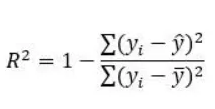  
El error absoluto medio representa el promedio de la diferencia absoluta entre los valores reales y predichos en el conjunto de datos. Mide el promedio de los residuos del conjunto de datos.  
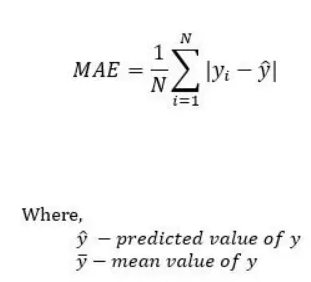  
El Error Cuadrático Medio representa el promedio de la diferencia al cuadrado entre los valores originales y predichos en el conjunto de datos. Mide la varianza de los residuos.  
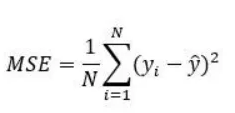  
La Raiz Cuadrática Media es la raíz cuadrada del error cuadrático medio. Mide la desviación estándar de los residuos.  
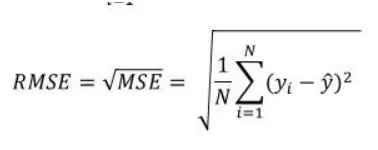

Diferencias entre estas métricas de evaluación  

El Error Cuadrático Medio (MSE) y la Raíz del Error Cuadrático Medio (RMSE) penalizan más los errores de predicción grandes en comparación con el Error Absoluto Medio (MAE). Sin embargo, el RMSE se usa más que el MSE para evaluar el rendimiento del modelo de regresión frente a otros modelos aleatorios, ya que tiene las mismas unidades que la variable dependiente (eje Y).

El MSE es una función diferenciable, lo que facilita operaciones matemáticas en comparación con funciones no diferenciables como el MAE. Por ello, en muchos modelos, el RMSE se usa como métrica predeterminada para calcular la función de pérdida, aunque sea más difícil de interpretar que el MAE.

Un valor más bajo de MAE, MSE o RMSE implica una mayor precisión del modelo de regresión. En cambio, un valor más alto de R cuadrado (R²) se considera deseable.

El R cuadrado y el R cuadrado ajustado explican qué tan bien las variables independientes del modelo de regresión lineal capturan la variabilidad de la variable dependiente. El valor de R² siempre aumenta al añadir variables independientes, lo que puede llevar a incluir predictores redundantes. No obstante, el R cuadrado ajustado resuelve este problema:

Considera el número de variables predictoras.

Determina si añadir una nueva variable mejora significativamente el modelo.

Disminuye si el incremento en R² por una variable adicional no es estadísticamente relevante.

Para comparar la precisión entre modelos de regresión lineal, el RMSE es mejor opción que el R².

Conclusión
Tanto el RMSE como el R² miden cómo se ajusta un modelo de regresión lineal a un conjunto de datos, pero con enfoques distintos:

El RMSE indica la capacidad del modelo para predecir el valor de la variable respuesta en términos absolutos.

El R² explica qué proporción de la variabilidad de la variable respuesta es capturada por las variables predictoras.

Mientras el RMSE es útil para evaluar errores de predicción concretos, el R² ayuda a entender el poder explicativo global del modelo.